In [1]:
import matplotlib.pyplot as plt

START_TIME = 1.0 # in seconds
BW = 100 # in Gbps
PORT_NO_START = 1000

In [2]:
#@title
def read_flow_stats(flow_stats_filename):

  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = float(flow_stat_log[0])*1e-9 - START_TIME # in seconds
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) * 1e-3 # in KB
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt # in Gbps
      elif (cwnd != 0):
        rate = BW

      if sender in flow_stats.keys():
        flow_stats[sender]['times'].append(time)
        flow_stats[sender]['rates'].append(rate)
        flow_stats[sender]['cwnds'].append(cwnd)
        flow_stats[sender]['rtts'].append(rtt)
      else:
        flow_stats[sender] = {}
        flow_stats[sender]['times'] = [time]
        flow_stats[sender]['rates'] = [rate]
        flow_stats[sender]['cwnds'] = [cwnd]
        flow_stats[sender]['rtts'] = [rtt]

  return flow_stats

In [3]:
#@title
def read_queue_log(filename):
  retval = {}
  retval['times'] = []
  retval['q_sizes'] = []
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-9 - START_TIME # in seconds
        q_size = float(queue_log[1]) * 8.0 / BW * 1e-3 # in usec
      except:
        continue

      retval['times'].append(time)
      retval['q_sizes'].append(q_size)

  return retval

In [10]:
#@title
def get_cum_cwnd(flow_stats):
  last_cwnd_of_senders = {}
  for sender in flow_stats.keys():
    last_cwnd_of_senders[sender] = 0

  cum_cwnds = {
      'times': [0],
      'cwnds': [0]
  }

  log_entries = []
  for sender, sender_logs in flow_stats.items():
    for i in range(len(sender_logs['times'])):
      log_entries.append((sender_logs['times'][i], sender_logs['cwnds'][i], sender))

  log_entries = sorted(log_entries, key=lambda x: x[0])

  for entry in log_entries:
    sender = entry[2]
    cum_cwnd = cum_cwnds['cwnds'][-1] - last_cwnd_of_senders[sender] + entry[1]
    cum_cwnds['cwnds'].append(cum_cwnd)
    cum_cwnds['times'].append(entry[0])
    last_cwnd_of_senders[sender] = entry[1]

  return cum_cwnds

# SWIFT & Bolt - Late Response to Congestion at New Flow Arrival

In [4]:
swift_filename = 'outputs/bolt-bts-benchmarks/0_SWIFT'
swift_flow_stats_filename = swift_filename + '.log'
swift_qlog_filename = swift_filename + '.qlen'
swift_flow_stats = read_flow_stats(swift_flow_stats_filename)
swift_qlog = read_queue_log(swift_qlog_filename)

swift_perhop_filename = 'outputs/bolt-bts-benchmarks/0_SWIFT_PERHOP'
swift_perhop_flow_stats_filename = swift_perhop_filename + '.log'
swift_perhop_qlog_filename = swift_perhop_filename + '.qlen'
swift_perhop_flow_stats = read_flow_stats(swift_perhop_flow_stats_filename)
swift_perhop_qlog = read_queue_log(swift_perhop_qlog_filename)

swift_perhop_bts_filename = 'outputs/bolt-bts-benchmarks/0_SWIFT_BTS_PERHOP'
swift_perhop_bts_flow_stats_filename = swift_perhop_bts_filename + '.log'
swift_perhop_bts_qlog_filename = swift_perhop_bts_filename + '.qlen'
swift_perhop_bts_flow_stats = read_flow_stats(swift_perhop_bts_flow_stats_filename)
swift_perhop_bts_qlog = read_queue_log(swift_perhop_bts_qlog_filename)

In [5]:
bolt_filename = 'outputs/bolt-bts-benchmarks/0_DEFAULT'
bolt_flow_stats_filename = bolt_filename + '.log'
bolt_qlog_filename = bolt_filename + '.qlen'
bolt_flow_stats = read_flow_stats(bolt_flow_stats_filename)
bolt_qlog = read_queue_log(bolt_qlog_filename)

In [6]:
xlim = [0.0005, 0.002]
ylim_rates = [0, BW*1.05]

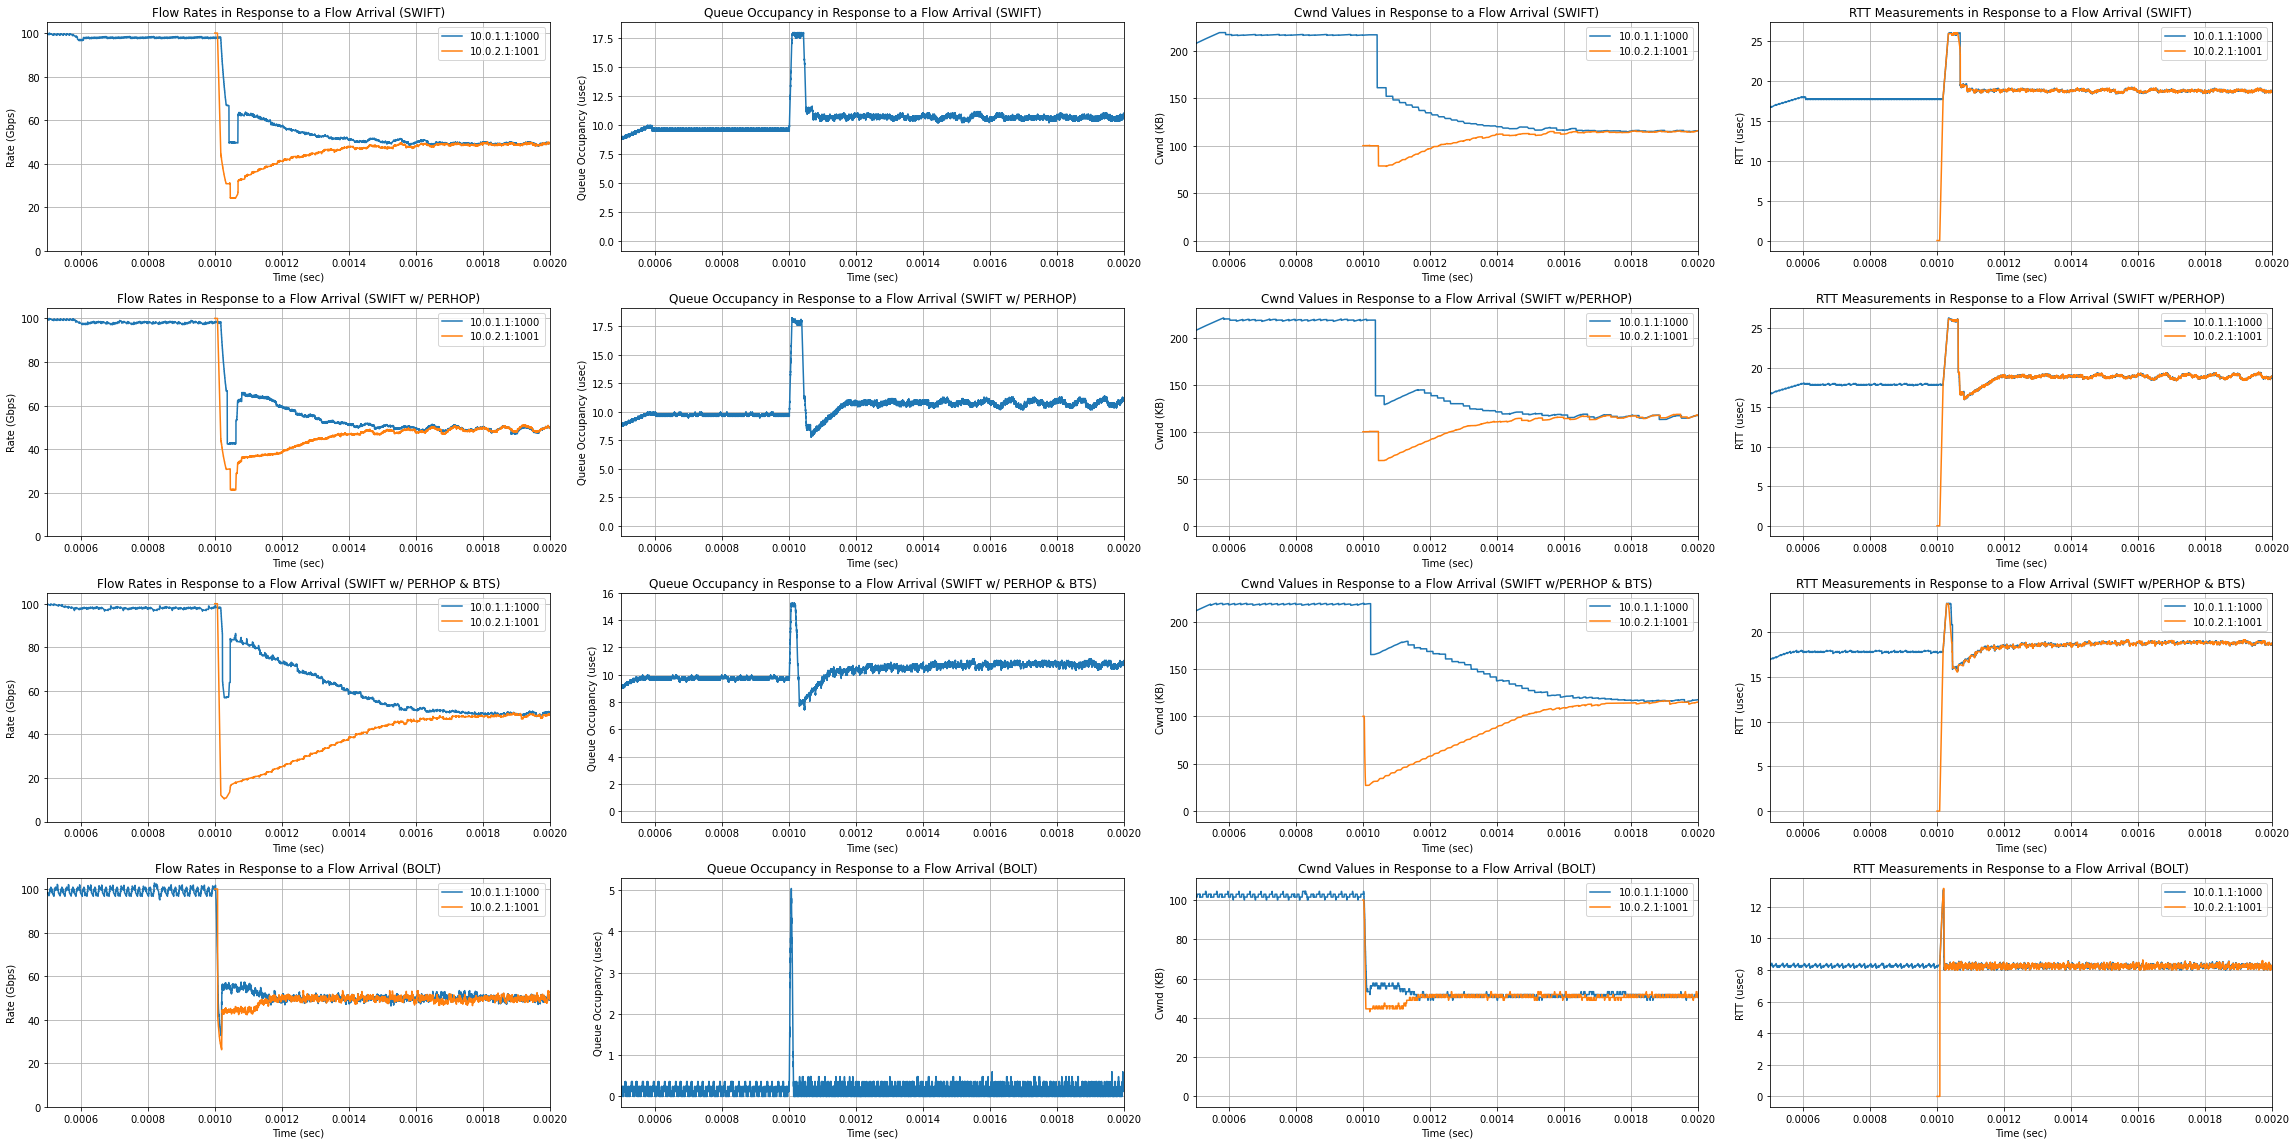

In [7]:
#@title
plt.figure(figsize=(32,16))

#####

plt.subplot(4,4,1)
for sender, stats in swift_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow Arrival (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(4,4,5)
for sender, stats in swift_perhop_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow Arrival (SWIFT w/ PERHOP)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(4,4,9)
for sender, stats in swift_perhop_bts_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow Arrival (SWIFT w/ PERHOP & BTS)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(4,4,13)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(4,4,2)
plt.plot(swift_qlog['times'],swift_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(4,4,6)
plt.plot(swift_perhop_qlog['times'],swift_perhop_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival (SWIFT w/ PERHOP)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()
#####

plt.subplot(4,4,10)
plt.plot(swift_perhop_bts_qlog['times'],swift_perhop_bts_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival (SWIFT w/ PERHOP & BTS)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(4,4,14)
plt.plot(bolt_qlog['times'],bolt_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(4,4,3)
for sender, stats in swift_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Arrival (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(4,4,7)
for sender, stats in swift_perhop_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Arrival (SWIFT w/PERHOP)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(4,4,11)
for sender, stats in swift_perhop_bts_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Arrival (SWIFT w/PERHOP & BTS)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(4,4,15)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(4,4,4)
for sender, stats in swift_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Arrival (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

#####

plt.subplot(4,4,8)
for sender, stats in swift_perhop_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Arrival (SWIFT w/PERHOP)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()
#####

plt.subplot(4,4,12)
for sender, stats in swift_perhop_bts_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Arrival (SWIFT w/PERHOP & BTS)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

#####

plt.subplot(4,4,16)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()
plt.show()

# Bolt - Closer View of Congestion Reaction

In [8]:
xlim_bolt = [0.001, 0.001025] # [0.00200144, 0.0020143] # 

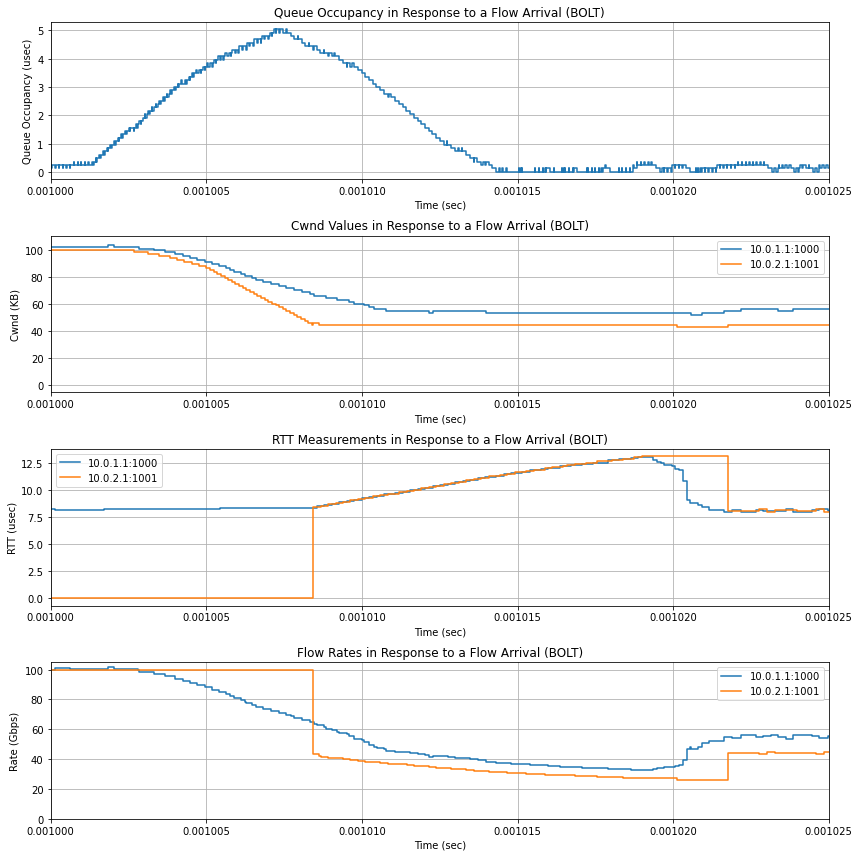

In [9]:
#@title
plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
plt.step(bolt_qlog['times'],bolt_qlog['q_sizes'], where='post')

if xlim_bolt is not None:
  plt.xlim(xlim_bolt)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

plt.subplot(4,1,2)
for sender, stats in bolt_flow_stats.items():
  plt.step(stats['times'],stats['cwnds'],label=sender, where='post')

if xlim_bolt is not None:
  plt.xlim(xlim_bolt)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

plt.subplot(4,1,3)
for sender, stats in bolt_flow_stats.items():
  plt.step(stats['times'],stats['rtts'],label=sender, where='post')

if xlim_bolt is not None:
  plt.xlim(xlim_bolt)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

plt.subplot(4,1,4)
for sender, stats in bolt_flow_stats.items():
  plt.step(stats['times'],stats['rates'],label=sender, where='post')

if xlim_bolt is not None:
  plt.xlim(xlim_bolt)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow Arrival (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()
plt.show()

# Swift & Bolt - Cumulative Cwnd During Congestion

In [11]:
bolt_cum_cwnds = get_cum_cwnd(bolt_flow_stats)
swift_cum_cwnds = get_cum_cwnd(swift_flow_stats)

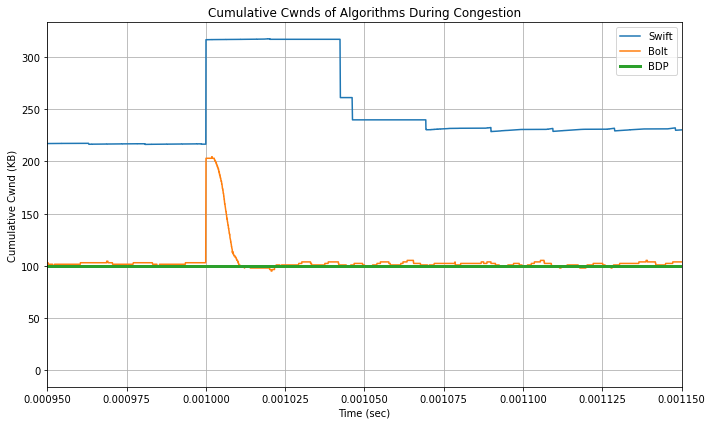

In [13]:
plt.figure(figsize=(10,6))
xlim_cum_cwnd = [0.00095, 0.00115]

plt.plot(swift_cum_cwnds['times'], swift_cum_cwnds['cwnds'], label='Swift')
plt.plot(bolt_cum_cwnds['times'], bolt_cum_cwnds['cwnds'], label='Bolt')
plt.axhline(y=100 , color='C2', linestyle='-', lw=3, label='BDP')

if xlim_cum_cwnd is not None:
  plt.xlim(xlim_cum_cwnd)

plt.title('Cumulative Cwnds of Algorithms During Congestion')
plt.xlabel('Time (sec)')
plt.ylabel('Cumulative Cwnd (KB)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()